In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import lmdb
import numpy as np
import torch.utils.data as data
from PIL import Image
import example_pb2

In [2]:
class Block(nn.Module):
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.block1=nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False),
                                 nn.BatchNorm2d(planes),
                                 nn.ReLU6()
        )
        self.block2=nn.Sequential(nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False),
                                 nn.BatchNorm2d(planes),
                                 nn.ReLU6()
        )
        self.block3=nn.Sequential(nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False), 
                                  nn.BatchNorm2d(out_planes),
        )

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, 
                          stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

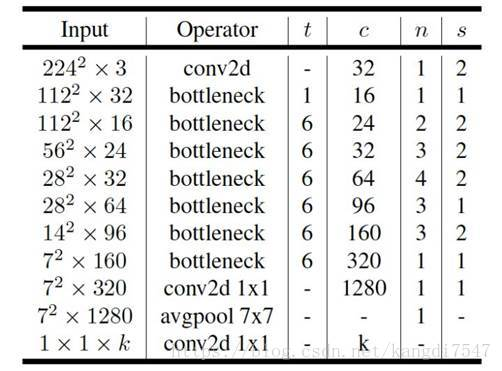

In [ ]:
class Model(nn.Module):
    #t,c,n,s
    cfg = [(6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2)]
    #t为扩张系数，c为输出通道数，n为该层重复的次数，s为步长
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU())
        self.layers = self._make_layers(in_planes=32)
        self.hidden2 = nn.Sequential(nn.Conv2d(160, 320, kernel_size=1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(320),
                                     nn.ReLU())
        self._digit11 = nn.Sequential(nn.Linear(320, 10))
        self._digit21 = nn.Sequential(nn.Linear(320, 10))
        
    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(
                    Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.size())
        x = self.hidden1(x)
        #print(x.size())
        x = self.layers(x)
        #print(x.size())
        x = self.hidden2(x)
        #print(x.size())
        x = F.avg_pool2d(x, 7)
        #print(x.size())
        x = x.view(x.size(0), -1)
        #print(x.size())

        digit1_logits = self._digit11(x)
        digit2_logits = self._digit21(x)

        return digit1_logits, digit2_logits

In [4]:
def calculloss(digit1_logits, digit2_logits,digits_labels):
    digit1_cross_entropy = torch.nn.functional.cross_entropy(digit1_logits, digits_labels[0])
    digit2_cross_entropy = torch.nn.functional.cross_entropy(digit2_logits, digits_labels[1])
    loss = digit1_cross_entropy + digit2_cross_entropy
    return loss
    
def train(model,device,train_loader,optimizer,epoch):
    for batch_idx, (images, digits_labels) in enumerate(train_loader):
        images, digits_labels = images.to(device), [digit_labels.to(device) for digit_labels in digits_labels]
        digit1_logits, digit2_logits= model.train()(images)
        loss = calculloss(digit1_logits, digit2_logits,digits_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("loss:",loss.item())
        
def test(model, device, test_loader):
    num_correct = 0
    with torch.no_grad():
        for batch_idx, (images,digits_labels) in enumerate(test_loader):
            images, digits_labels = images.to(device),[digit_labels.to(device) for digit_labels in digits_labels]
            digit1_logits, digit2_logits= model.eval()(images)

            digit1_prediction = digit1_logits.max(1)[1]
            digit2_prediction = digit2_logits.max(1)[1]

            num_correct += (digit1_prediction.eq(digits_labels[0]) &
                            digit2_prediction.eq(digits_labels[1])).cpu().sum()

    accuracy = 100*num_correct.item() / len(test_loader.dataset)
    print("accuracy:",accuracy)
    return accuracy

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, path_to_lmdb_dir, transform):
        self._path_to_lmdb_dir = path_to_lmdb_dir
        self._reader = lmdb.open(path_to_lmdb_dir, lock=False)
        with self._reader.begin() as txn:
            self._length = txn.stat()['entries']
            self._keys = self._keys = [key for key, _ in txn.cursor()]
        self._transform = transform

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        with self._reader.begin() as txn:
            value = txn.get(self._keys[index])

        example = example_pb2.Example()
        example.ParseFromString(value)

        image = np.frombuffer(example.image, dtype=np.uint8)
        image = image.reshape([54, 54, 3])
        image = Image.fromarray(image)
        image = self._transform(image)

        length = example.length
        digits = example.digits

        return image, digits

In [ ]:
device = torch.device("cuda")
    
path_to_train_lmdb_dir = "/home/chz/SVHN/train.lmdb"
path_to_val_lmdb_dir = "/home/chz/SVHN/val.lmdb"
    
train_transform = transforms.Compose([
            transforms.RandomRotation(degrees=(-30,30)),
            transforms.ColorJitter(brightness=0.7, contrast=.5, saturation=.1, hue=.1),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
train_loader = torch.utils.data.DataLoader(Dataset(path_to_train_lmdb_dir, train_transform),
                                               batch_size=128, shuffle=True,num_workers=12)
test_transform = transforms.Compose([
            transforms.RandomRotation(degrees=(-30,30)),
            transforms.ColorJitter(brightness=0.7, contrast=.5, saturation=.1, hue=.1),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
test_loader = torch.utils.data.DataLoader(Dataset(path_to_val_lmdb_dir, test_transform), batch_size=128, shuffle=False,num_workers=12)

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), 0.008,momentum=0.7)

old_test_acc=0

for epoch in range(1, 40 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test_acc = test(model, device, test_loader)
    if test_acc>=old_test_acc:
        old_test_acc=test_acc
        torch.save(model.state_dict(), "mobilenet.pth")

In [ ]:
from torchvision import transforms
from PIL import Image
def _infer(path_to_checkpoint_file, path_to_input_image):
    model = Model()
    model.load_state_dict(torch.load(path_to_checkpoint_file))
    model.cuda()
    
    with torch.no_grad():
        transform = transforms.Compose([
            transforms.Resize([64, 64]),
            transforms.CenterCrop([54, 54]),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

        image = Image.open(path_to_input_image)
        image = image.convert('RGB')
        image = transform(image)
        images = image.unsqueeze(dim=0).cuda()
        print(images.size())

        digit1_logits, digit2_logits= model.eval()(images)
        traced_script_module = torch.jit.trace(model, images)
        traced_script_module.save("mobilenet.pt")

        digit1_prediction = digit1_logits.max(1)[1]
        digit2_prediction = digit2_logits.max(1)[1]

        print('digits:', digit1_prediction.item(), digit2_prediction.item())

In [ ]:
path_to_checkpoint_file='mobilenet.pth'
path_to_input_image="images//test-75.png"
_infer(path_to_checkpoint_file, path_to_input_image)